In [1]:
import matplotlib.pyplot as plt
import numpy as np
from util_module import show_model
from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

- 모델 만들기

| |  $yes$  | $no$ |
| --- | --- | --- |
| $Sunny$ |   0.10  | 0.90 |
| $Rainy$ | 0.80 | 0.20 |

In [6]:
model = HiddenMarkovModel()

- Emmision 정의해주고, State에 넣어주면서 State 정의

In [7]:
sunny_emmision = DiscreteDistribution({'yes':0.1, 'no':0.9})
sunny_state = State(sunny_emmision, name='Sunny')

rainy_emmision = DiscreteDistribution({'yes':0.8, 'no':0.2})
rainy_state = State(rainy_emmision, name='rainy')

In [8]:
model.add_states(sunny_state, rainy_state)

## Initial Probability $P(X_0)$:

| $Sunny$ | $Rainy$ |
| --- | ---
| 0.5 | 0.5 |

## State transition probabilities $P(X_{t} | X_{t-1})$

| | $Sunny$ | $Rainy$ |
| --- | --- | --- |
|$Sunny$| 0.80 | 0.20 |
|$Rainy$| 0.40 | 0.60 |

- 초기확률 정의
     - $\pi$

- 모델 시작점에서 sunny_state로 가능 확률 
    - 즉, sunny_state의 시작확률

In [9]:
model.add_transition(model.start, sunny_state, 0.5)
model.add_transition(model.start, rainy_state, 0.5)

- transition 확률 정의

In [10]:
model.add_transition(sunny_state, sunny_state, 0.8)
model.add_transition(sunny_state, rainy_state, 0.2)
model.add_transition(rainy_state, sunny_state, 0.4)
model.add_transition(rainy_state, rainy_state, 0.6)

- 모델을 구워주자. 이제 다 넣었음
    - moel.bake()

In [11]:
model.bake()

In [12]:
model.edge_count()

6

In [13]:
model.node_count()

4

## Visualize the Network

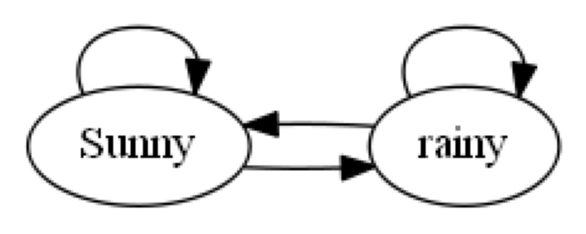

In [14]:
show_model(model, figsize=(5, 5), filename="example.png", overwrite=True, show_ends=False)

### Checking the Model

In [15]:
model.states[3].name

'None-end'

In [16]:
# 순서를 재정의해야함
column_order = ["None-start", "Sunny", "rainy", "None-end"] 

In [17]:
column_names = [s.name for s in model.states]
column_names

['Sunny', 'rainy', 'None-start', 'None-end']

In [18]:
order_index = [column_names.index(c) for c in column_order]
order_index

[2, 0, 1, 3]

- 로우, 칼럼이
    - 인덱스 2, 0, 1, 3으로 됨

In [19]:
model.dense_transition_matrix()[:,order_index][order_index,:]

array([[0. , 0.5, 0.5, 0. ],
       [0. , 0.8, 0.2, 0. ],
       [0. , 0.4, 0.6, 0. ],
       [0. , 0. , 0. , 0. ]])

In [20]:
transitions = model.dense_transition_matrix()[:,order_index][order_index,:]

In [30]:
print("상태천이행렬 : P(Xt|Xt-1):\n")
print(transitions)
print("\n Rainy에서 Sunny로의 천이확률은 {:.0f}%".format(100 * transitions[2, 1]))

상태천이행렬 : P(Xt|Xt-1):

[[0.  0.5 0.5 0. ]
 [0.  0.8 0.2 0. ]
 [0.  0.4 0.6 0. ]
 [0.  0.  0.  0. ]]

 Rainy에서 Sunny로의 천이확률은 40%


## Sequence Likelihood

- Evaluation

- data가 들어왔다.

In [31]:
observations = ['yes','no','yes']

- log-likelihood값이므로, 이걸 np.exp로 likelihood로 바꿔줘야함

In [32]:
np.exp(model.forward(observations))

array([[0.    , 0.    , 1.    , 0.    ],
       [0.05  , 0.4   , 0.    , 0.    ],
       [0.18  , 0.05  , 0.    , 0.    ],
       [0.0164, 0.0528, 0.    , 0.    ]])

In [33]:
forward_matrix = np.exp(model.forward(observations))

In [34]:
model.log_probability(observations)

-2.6707544163585126

In [35]:
np.exp(model.log_probability(observations))

0.06920000000000004

In [36]:
probability_percent = np.exp(model.log_probability(observations))

In [38]:
# forward prob
print("         " + "".join(s.name.center(len(s.name)+6) for s in model.states))
for i in range(len(observations) + 1):
    print(" <start> " if i==0 else observations[i - 1].center(9), end="")
    print("".join("{:.0f}%".format(100 * forward_matrix[i, j]).center(len(s.name) + 6)
                  for j, s in enumerate(model.states)))

print("\nThe likelihood over all possible paths " + \
      "of this model producing the sequence {} is {:.2f}%\n\n"
      .format(observations, 100 * probability_percent))

            Sunny      rainy      None-start      None-end   
 <start>      0%         0%          100%            0%      
   yes        5%        40%           0%             0%      
    no       18%         5%           0%             0%      
   yes        2%         5%           0%             0%      

The likelihood over all possible paths of this model producing the sequence ['yes', 'no', 'yes'] is 6.92%




### Decoding the Most Likely Hidden State Sequence

- Decoding

- Data가 들어왔다.

In [39]:
observations = ['yes', 'no', 'yes']

In [40]:
model.viterbi(observations)

(-3.7705234431544463,
 [(2, {
       "class" : "State",
       "distribution" : null,
       "name" : "None-start",
       "weight" : 1.0
   }),
  (1,
   {
       "class" : "State",
       "distribution" : {
           "class" : "Distribution",
           "dtype" : "str",
           "name" : "DiscreteDistribution",
           "parameters" : [
               {
                   "yes" : 0.8,
                   "no" : 0.2
               }
           ],
           "frozen" : false
       },
       "name" : "rainy",
       "weight" : 1.0
   }),
  (0,
   {
       "class" : "State",
       "distribution" : {
           "class" : "Distribution",
           "dtype" : "str",
           "name" : "DiscreteDistribution",
           "parameters" : [
               {
                   "yes" : 0.1,
                   "no" : 0.9
               }
           ],
           "frozen" : false
       },
       "name" : "Sunny",
       "weight" : 1.0
   }),
  (1,
   {
       "class" : "State",
       "distri

- sequence likelihood와 best path 구하기
    - 물론 가능도는 log_likelihood로 나옴

In [41]:
# sequence likelihood
viterbi_likelihood, viterbi_path = model.viterbi(observations)

In [42]:
viterbi_path[0]

(2,
 {
     "class" : "State",
     "distribution" : null,
     "name" : "None-start",
     "weight" : 1.0
 })

- path는 index 1부터

In [43]:
viterbi_path[1][1].name

'rainy'

In [44]:
print("The most likely weather sequence to have generated " + \
      "these observations is {} at {:.2f}%."
      .format([s[1].name for s in viterbi_path[1:]], np.exp(viterbi_likelihood)*100)
)

The most likely weather sequence to have generated these observations is ['rainy', 'Sunny', 'rainy'] at 2.30%.


### Forward likelihood vs Viterbi likelihood

In [45]:
from itertools import product

observations = ['no', 'no', 'yes']

p = {'Sunny': {'Sunny': np.log(.8), 'Rainy': np.log(.2)}, 'Rainy': {'Sunny': np.log(.4), 'Rainy': np.log(.6)}}
e = {'Sunny': {'yes': np.log(.1), 'no': np.log(.9)}, 'Rainy':{'yes':np.log(.8), 'no':np.log(.2)}}
o = observations
k = []
vprob = np.exp(model.viterbi(o)[0])
print("The likelihood of observing {} if the weather sequence is...".format(o))
for s in product(*[['Sunny', 'Rainy']]*3):
    k.append(np.exp(np.log(.5)+e[s[0]][o[0]] + p[s[0]][s[1]] + e[s[1]][o[1]] + p[s[1]][s[2]] + e[s[2]][o[2]]))
    print("\t{} is {:.2f}% {}".format(s, 100 * k[-1], " <-- Viterbi path" if k[-1] == vprob else ""))
print("\nThe total likelihood of observing {} over all possible paths is {:.2f}%".format(o, 100*sum(k)))

The likelihood of observing ['no', 'no', 'yes'] if the weather sequence is...
	('Sunny', 'Sunny', 'Sunny') is 2.59% 
	('Sunny', 'Sunny', 'Rainy') is 5.18%  <-- Viterbi path
	('Sunny', 'Rainy', 'Sunny') is 0.07% 
	('Sunny', 'Rainy', 'Rainy') is 0.86% 
	('Rainy', 'Sunny', 'Sunny') is 0.29% 
	('Rainy', 'Sunny', 'Rainy') is 0.58% 
	('Rainy', 'Rainy', 'Sunny') is 0.05% 
	('Rainy', 'Rainy', 'Rainy') is 0.58% 

The total likelihood of observing ['no', 'no', 'yes'] over all possible paths is 10.20%
